# Introduction
This notebook shows how to estimate sparse inverse covariance matrices.

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import yfinance as yf
import matplotlib.pyplot as plt

# Setup

### Universe and objective
We consider a universe of four assets, tracking the USA, Europe, Asia and Africa
stock markets, during 2007-2024 The objective is to estimate a covariance matrix for these
assets. We want the inverse covariance matrix to be sparse. The meaning of this
(under a Gaussian assumption) is the following: the inverse covariance matrix
between two assets is zero if and only if the two assets are conditionally
independent given the other assets. For example, if the inverse covariance 
between the USA and Europe stock markets is zero, then the USA and Africa stock
markets are conditionally independent given the returns of the Asia and Europe
stock markets.

In [2]:
usa = yf.Ticker('SPY')
europe = yf.Ticker('VGK')
asia = yf.Ticker('AAXJ')
africa = yf.Ticker('AFK')

start = '2007-01-01'
end = '2024-05-31'

usa = usa.history(period='1d', start=start, end=end).Close
europe = europe.history(period='1d', start=start, end=end).Close
asia = asia.history(period='1d', start=start, end=end).Close
africa = africa.history(period='1d', start=start, end=end).Close

# remove time zones
usa.index = usa.index.tz_localize(None)
europe.index = europe.index.tz_localize(None)
asia.index = asia.index.tz_localize(None)
africa.index = africa.index.tz_localize(None)

prices = pd.concat([usa, europe, asia, africa], axis=1).ffill().dropna()
prices.columns = ['USA', 'Europe', 'Asia', 'Africa']
returns = prices.pct_change().dropna()

# Sparse inverse covariance estimation problem

### Problem statement
We model the returns of the four assets as a zero-mean Gaussian random vector
$$
r_t \sim \mathcal{N}(0, \Sigma)
$$
where $r_t$ is the returns vector at time $t$ and $\Sigma$ is the covariance
matrix. The precision matrix is the inverse of the covariance matrix, $\theta =
\Sigma^{-1}$. The log-likelihood at time $t$ is
$$
l_t(\theta) =
        \frac{1}{2}\left(-n\log(2\pi) + \log\det \theta - r_t^T \theta
        r_t\right).
$$
To attain a sparse precision matrix, we consider the following optimization
problem:
$$
\begin{array}{ll}
        \text{maximize}   & \sum_{t=1}^T l_t(\theta) - \lambda 
\sum_{i < j} |\theta_{ij}| \\
        \text{subject to} & \theta \succeq 0,
    \end{array}
$$
with variable $\theta$, where
$\lambda>0$ is a (sparsity) regularization parameter.



In [3]:
def solve_spares_inverse_problem(returns, lam, solver="CLARABEL"):
    """
    Solve the sparse inverse problem using CVXPY."""
    T, n = returns.shape

    Theta = cp.Variable((n, n), PSD=True)

    S = returns.T @ returns / T
    log_likelihood = T / 2 * (cp.log_det(Theta) -  cp.trace(Theta @ S))

    mask = np.triu(np.ones((n, n)), k=1).astype(bool)
    objective = log_likelihood - lam * cp.norm1(Theta[mask])

    prob = cp.Problem(cp.Maximize(objective))
    prob.solve(verbose=False, solver=solver)

    return Theta.value



# Example
The following code snippet shows how the sparsity structure evolves over time
for regularization parameter $\lambda=0.05$. (White boxes denote zero entries.)

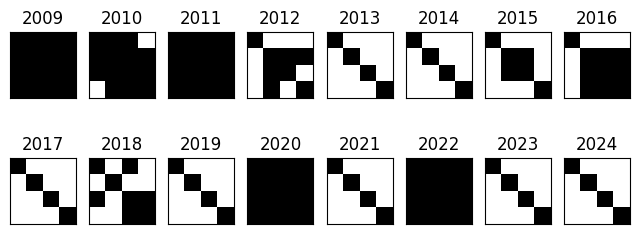

In [4]:
lam = 0.025
years = returns.index.year.unique()[1:]

fig, axs = plt.subplots(2, 8, figsize=(8, 3))


for i, year in enumerate(years):
    returns_year = returns.loc[str(year)]
    Theta = solve_spares_inverse_problem(returns_year.values, lam)
    Theta = pd.DataFrame(Theta, index=returns_year.columns, columns=returns_year.columns).astype(int)

    mean_diag = np.mean(np.diag(Theta))
    bools = Theta.abs() < 0.001*mean_diag 
    ax = axs[i // 8, i % 8]

    im = ax.imshow(bools, cmap="gray")  
    ax.set_title("{}".format(year))
    ax.set_xticks([])
    ax.set_yticks([])
    
# plt.savefig('../yearly_sparsity.pdf', bbox_inches='tight', pad_inches=0)